# Volatility Surface Calibration
BS 常数波动解释不了市场报价（skew/smile/term-structure）。

做市/定价要“与市场一致”：把各期限/行权的报价变成一个可用的曲面，后续所有 vanilla/exotic 都在此曲面下定价/对冲。

>Surface 是“一致性引擎”。定价与风险都绑定在面曲上；不一致会导致对冲 P&L 漂移。

## 🧩 一、S&T 框架下的核心思想：

> 市场报的是「期权价格」 → 我们**倒推 implied vol surface** →
> 再用该 surface 去「定价」「风险管理」「对冲」。

所以核心顺序是：

### (1) 市场上能观察到的是：

* 每个 strike K、到期 T 的期权 **market price (V_{mkt}(K,T))**
  例如 Bloomberg 上的 vanilla call/put quote。

### (2) 我们通过模型（如 Black–Scholes）倒推出 implied volatility：

$
V_{mkt}(K,T) = BS(S_0, K, r, q, \sigma_{imp}(K,T), T)
$
→ 求出使等式成立的 σ_imp，即「market implied volatility」。

**得到一张 implied vol surface $ \sigma_{imp}(K,T) $。**

---

## 🧭 二、为什么还要“calibrate surface”（校准波动率曲面）

现实中的 IV surface 通常：

* 随 strike 有 **smile / skew**；
* 随 maturity 有 **term structure**；
* 市场每天都会更新。

但是直接用一堆散点的 σ_imp(K,T) 不方便用于：

* Barrier / exotic 定价（它们需要连续的波动率输入）；
* 风险管理（要能求 Vega / Vol Shift）。

所以我们希望找到一个**光滑的函数模型 $ \sigma_{model}(K,T;\theta) $**，
使得：
$
\sigma_{model}(K_i,T_i;\theta) \approx \sigma_{imp}^{mkt}(K_i,T_i)
$
→ 通过优化参数 θ，最小化误差。

---

## 🔧 三、常用的 calibration 模型（实盘里）

| 模型                                       | 数学形式                                                                          | Desk用途                    | 难度   |
| ---------------------------------------- | ----------------------------------------------------------------------------- | ------------------------- | ---- |
| **SABR**                                 | stochastic vol model: $($ dF = \alpha F^\beta dW_1, d\alpha = \nu \alpha dW_2 $)$ | vanilla smile, FX/IR desk | ⭐⭐⭐  |
| **SVI (Stochastic Volatility Inspired)** | $ w(k) = a + b(\rho (k - m) + \sqrt{(k - m)^2 + \sigma^2}) $              | equity vol surface        | ⭐⭐   |
| **Local Vol (Dupire)**                   | 反推出 σ_loc(S,t)                                                                | exotic pricing, hedging   | ⭐⭐⭐⭐ |
| **Parametric polynomial / spline fit**   | purely empirical                                                              | fast indicative pricing   | ⭐    |

> 💡在 S&T desk，SVI + smoothing 是最常见的 daily fit，
> 因为快、稳定、可直接生成 Vega surface。

---

## 🏦 四、在卖方 S&T desk 实际上的用途

| 环节                   | 用途                          | 举例                              |
| -------------------- | --------------------------- | ------------------------------- |
| **Market making**    | 从 vanilla quote 建 surface   | 每日 SVI calibration              |
| **Exotic pricing**   | 把 surface 填进 PDE/MC 模型      | Barrier, Cliquet, Range accrual |
| **Risk management**  | 计算 smile Vega、Volga         | Vega bucket by strike/maturity  |
| **Client quoting**   | 给 buy-side 报价，用 own surface | Structured note pricing         |
| **Scenario testing** | 模拟 “smile shift”            | +1 vol shock → PnL Δ            |

---

## ✅ 总结一句话

> Calibration = 从市场报价构造“连续、可用”的 volatility surface
> → 用于 exotic 定价、风险管理、报价、hedging。
>
> 你模拟的“合成 market IV → 拟合 model surface → 用回 exotic model”
> 正是卖方 daily workflow 的 miniature 版本。



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
S0 = 100
K = 100
r = 0.02
q = 0
sigma = 0.2
T = 1
steps = 50 
seed = 12345

In [27]:
import numpy as np
from deriv_pricing.vol_surface import make_synthetic_surface_ts

strikes = np.linspace(60,160,20)
tenors=[0.25,0.5,1.0]


# 返回 dict: {(T, K): iv}
iv_fact = make_synthetic_surface_ts(S0, r, q, strikes, tenors, rho_fn = lambda T: 0)


In [28]:
iv_fact.values()

dict_values([np.float64(0.22945980334965269), np.float64(0.22454846894413094), np.float64(0.22055009781015295), np.float64(0.21738509172460266), np.float64(0.21497944983395784), np.float64(0.21326094544237878), np.float64(0.21215753675922994), np.float64(0.21159745034028304), np.float64(0.2115103138894942), np.float64(0.21182872628980265), np.float64(0.21248977009900438), np.float64(0.21343615634558466), np.float64(0.2146168785646372), np.float64(0.21598739403559247), np.float64(0.2175094287225889), np.float64(0.21915052743305016), np.float64(0.22088346167848438), np.float64(0.22268558316509368), np.float64(0.22453818339294568), np.float64(0.22642589604750982), np.float64(0.23549554822810467), np.float64(0.2313451332171974), np.float64(0.22799474032092684), np.float64(0.22536002690436696), np.float64(0.22336489881639798), np.float64(0.22193870647408134), np.float64(0.22101495804682506), np.float64(0.2205310058114265), np.float64(0.220428264125853), np.float64(0.22065262123072352), np.f

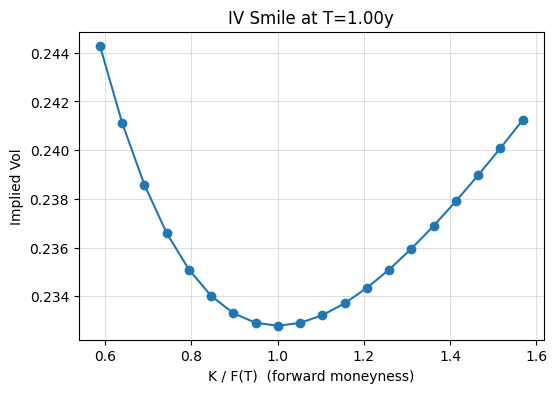

In [29]:
# Plot
from deriv_pricing.vol_surface import plot_smile, plot_surface

plot_smile(iv_fact, T, strikes, S0, r, q)

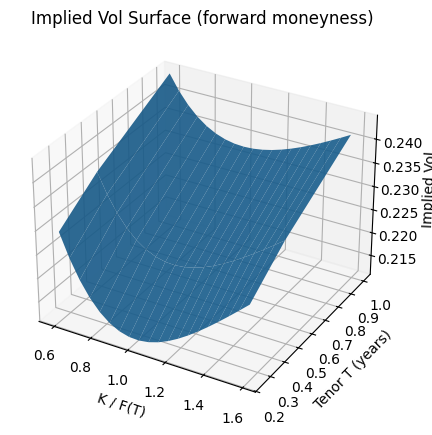

In [30]:
plot_surface(iv_fact, strikes, tenors, S0, r, q)

In [ ]:
# Calibrate
from deriv_pricing.vol_surface import prepare_kw_table, svi_raw, calibrate_svi_by_tenor, sigma_from_surface 

bounds = [(-5, 5), (1e-6, 10.0), (-0.999, 0.999), (-2.0, 2.0), (1e-6, 5.0)]

In [35]:
kw_table = prepare_kw_table(iv_fact, S0, r, q)
fitted = calibrate_svi_by_tenor(kw_table)


In [38]:
print("Fitted SVI params by tenor:")
for T in sorted(fitted.keys()):
    a,b,rho,m,sig = fitted[T]
    print(f"T={T:.4f}: a={a:.6f}, b={b:.6f}, rho={rho:.4f}, m={m:.4f}, sigma={sig:.4f}")


Fitted SVI params by tenor:
T=0.2500: a=0.005807, b=0.011003, rho=-0.3773, m=-0.2552, sigma=0.5272
T=0.5000: a=0.011955, b=0.016447, rho=-0.3586, m=-0.2464, sigma=0.5441
T=1.0000: a=0.033774, b=0.022654, rho=-0.3634, m=-0.2321, sigma=0.4915


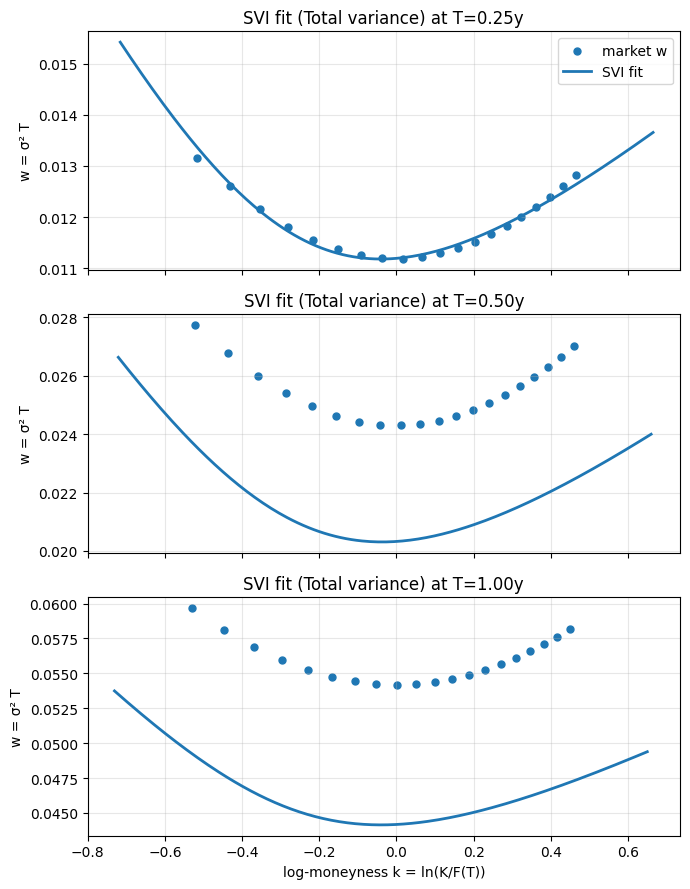

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(tenors), 1, figsize=(7, 3*len(tenors)), sharex=True)
if len(tenors) == 1:
    axes = [axes]
for ax, T in zip(axes, sorted(kw_table.keys())):
    k = np.array(kw_table[T]["k"])
    w = np.array(kw_table[T]["w"])
    # 拟合曲线
    a,b,rho,m,sig = fitted[T]
    k_grid = np.linspace(k.min()-0.2, k.max()+0.2, 200)
    w_fit = svi_raw(k_grid, a,b,rho,m,sig)
    ax.scatter(k, w, label="market w", s=25)
    ax.plot(k_grid, w_fit, label="SVI fit", lw=2)
    ax.set_title(f"SVI fit (Total variance) at T={T:.2f}y")
    ax.set_ylabel("w = σ² T")
    ax.grid(alpha=0.3)
axes[-1].set_xlabel("log-moneyness k = ln(K/F(T))")
axes[0].legend()
plt.tight_layout()


In [42]:
T_dense = np.linspace(min(tenors), max(tenors), 30)
# 为了跨期限一致比较，这里用同一组 strikes；也可以每个T围绕F(T)构造不同的K
K_dense = np.linspace(strikes.min(), strikes.max(), 41)

# 评估拟合后的 σ(K,T)
Z = np.zeros((len(T_dense), len(K_dense)))
for i, T in enumerate(T_dense):
    for j, K in enumerate(K_dense):
        Z[i,j] = sigma_from_surface(S0, r, q, fitted, K, T)

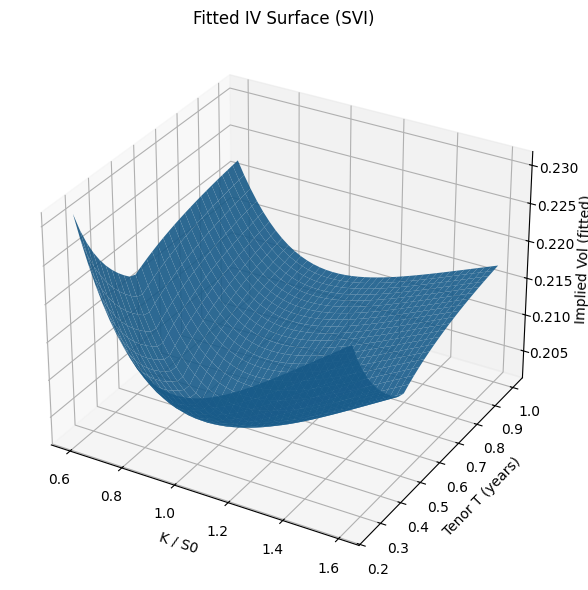

In [43]:
from mpl_toolkits.mplot3d import Axes3D  # noqa
X, Y = np.meshgrid(K_dense / S0, T_dense)  # 为直观，这里横轴用 K/S0；也可改成 K/F(T)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("K / S0")
ax.set_ylabel("Tenor T (years)")
ax.set_zlabel("Implied Vol (fitted)")
ax.set_title("Fitted IV Surface (SVI)")
plt.tight_layout()

In [44]:
from deriv_pricing.black_scholes import bs_european_option
from deriv_pricing.barrier import price_barrier_rr

#=== 7) 用校准后的 surface 做定价（示例：Vanilla & Barrier）===
# 先取一个 (K,T) 点，从 surface 拿 σ，再喂进你的定价器
K_ex = 100.0
T_ex = 1.0
sigma_ex = sigma_from_surface(S0, r, q, fitted, K_ex, T_ex)
print(f"\nExample σ from fitted surface at (K={K_ex}, T={T_ex}): {sigma_ex:.4%}")

# 如果你环境里有这两个定价器，就可以直接用：
try:
    # 1) 欧式 vanilla
    price_call = bs_european_option(S0, K_ex, r, q, sigma_ex, T_ex, 'call')
    # 2) Barrier（近似：用该 σ 喂进 RR；更进阶可用 LocalVol PDE/MC）
    price_do = price_barrier_rr(S0, K_ex, B=95.0, r=r, q=q, sigma=sigma_ex, T=T_ex,
                                option='call', barrier_type='down', knock='out')
    print(f"Vanilla call (fitted σ): {price_call:.6f}")
    print(f"Down-and-out call (fitted σ): {price_do:.6f}")
except NameError:
    print("⚠️ 备注：未找到 bs_european_option / price_barrier_rr；"
          "如需演示定价，请先在环境中导入/定义它们。")


Example σ from fitted surface at (K=100.0, T=1.0): 21.0131%
Vanilla call (fitted σ): 9.312201
Down-and-out call (fitted σ): 4.700054


在交易台口径中：

* 一个 **vol surface** 是在一个 **特定的 market snapshot（即特定的 spot、rates、dividend）** 下构建的。
  换句话说：
  $
  σ_{surface} = σ(K, T; S_0, r, q)
  $
  但当你在 calibration 时，S₀、r、q 都是固定参数。

因此：

* **输入变量**：strike (K)、到期 (T)
* **隐含假设**：spot (S₀)、rate (r)、dividend (q) 在校准当时是固定的（所有 option quote 都是基于那一刻的 market state）

---

### 💼 在实际交易系统中是这样做的：

#### 1️⃣ 每个 trading day 都会有一个 “market snapshot”

包含：

| 参数             | 含义                                                     |
| -------------- | ------------------------------------------------------ |
| (S_0)          | 当前标的价格                                                 |
| (r(T))         | 各期限的 risk-free zero curve（bootstrapped）                |
| (q(T))         | 各期限的 dividend/yield curve                              |
| (σ_{mkt}(K,T)) | 从市场 quote（delta 或 moneyness basis）得到的 implied vol grid |

这些共同构成了当天的 “Vol Surface Environment”。

---

#### 2️⃣ 在这个环境下：

SVI surface 表达为：
$
σ(K,T) = f_{SVI}(K, T; \Theta)
$
其中 (\Theta(T) = {a(T), b(T), ρ(T), m(T), σ(T)}) 是你拟合出的参数族。

---

#### 3️⃣ 当你 pricing 时：

* 你固定该 day 的 (S_0, r, q)
* 对于想要定价的任何 (K,T)，查表或插值找到对应的 implied vol
* 用该 vol 喂进 Black–Scholes 或更复杂模型计算价格

---

### ⚙️ 举个例子：

今天是 2025-10-08，desk 观测：

* (S₀ = 100)
* (r = 2%)
* (q = 0)
* 市场给出 smile：

  * (T=1M,3M,6M,1Y)
  * 每个 T 上的不同 delta 对应 implied vol

Quant / Structurer 通过 **SVI calibration** 得到：
$
σ_{SVI}(K,T)
$

在此基础上：

```python
# 用 calibrated surface 给 barrier option 定价
sigma = sigma_from_surface(S0, r, q, fitted, K=95, T=0.5)
price_barrier_rr(S0, K=95, B=90, r=r, q=q, sigma=sigma, T=0.5,
                 option='call', barrier_type='down', knock='out')
```

这里 S₀, r, q 都是 calibration 时的 market snapshot 常数。

---

## 🔄 延伸：如果市场变动（S₀, r, q 变了）

那 desk 会重新：

* 用新的 forward $F(T) = S_0 e^{(r-q)T}$
* 用新的 moneyness grid（通常以 **delta basis**）
* **重建或 shift surface**（例如 sticky-delta 或 sticky-strike rule）

---

## 🧭 总结成一句话

> 📘
> Vol surface (σ(K,T)) 是一个**两维函数**，定义在固定的 market snapshot 上（给定 (S₀, r, q)）。
> 它描述不同到期和行权价下的市场隐含波动率结构。
> 当市场变动时，要么重新标定，要么使用规则（sticky-delta 等）动态调整。
